In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv(r"continuous_factory_process.csv", delimiter=",")
df.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


# Cleaning
Tijdens de data understanding zijn bepaalde cellen, rijen of kolommen ontdekt waarin opmerkelijkheden waargenomen zijn. Zo waren er een aantal dubbele of missende tijdstempels, incidentele negatieve waarden in verder verklaarbare natuurlijke getallen ($\mathbb{N}$) en nog andere voorbeelden.

## Time stamps
### Dubbele Tijdtempels checken

In [279]:
ts = df['time_stamp']
duplicate_values = ts.duplicated()

count_true_false = duplicate_values.value_counts()

print(count_true_false)
print(duplicate_values[duplicate_values])

time_stamp
False    14074
True        14
Name: count, dtype: int64
20       True
35       True
36       True
1679     True
3067     True
3810     True
5521     True
6671     True
8719     True
8812     True
9669     True
10290    True
11830    True
13162    True
Name: time_stamp, dtype: bool


*20, 35, 36, 1679, 3067, 3810, 5521, 6671, 8719, 8812, 9669, 10290, 11830, 13162*

Zijn allemaal de index cijfers van een dubbele tijdstempel.

In [280]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

time_diff = df['time_stamp'].diff()

ts_df = df[['time_stamp']]

missing_items = ts_df[time_diff > pd.Timedelta(seconds=1)]

print(f"Number of missing time stamps: {len(missing_items)}")
print(f"Rows with missing items: \n {missing_items}")

Number of missing time stamps: 14
Rows with missing items: 
                time_stamp
922   2019-03-06 11:07:53
2026  2019-03-06 11:26:17
5711  2019-03-06 12:27:40
6030  2019-03-06 12:33:00
6502  2019-03-06 12:40:53
8589  2019-03-06 13:15:40
9037  2019-03-06 13:23:07
9558  2019-03-06 13:31:49
9885  2019-03-06 13:37:16
10432 2019-03-06 13:46:23
10755 2019-03-06 13:51:47
11038 2019-03-06 13:56:31
11501 2019-03-06 14:04:15
12750 2019-03-06 14:25:04


*922, 2026, 5711, 6030, 6502, 8589, 9037, 9558, 9885, 10432, 10755, 11038, 11501, 12750*

Zijn allemaal de index cijfers een 'missende' tijdstempel. 

Omdat de tijd (hoogstwaarschijnlijk) een relatieve factor speelt, en er heel veel features zijn waar een model op gebaseerd kan worden, wordt de tijd voor nu niet 'opgeschoont'. Als het post-model creatie zorgt voor betere resultaten zal het vernieuwde model aangenomen worden.

## Negatieve getallen in de measurements

Bij het inspecteren van de dataset in een spreadsheet werd opgemerkt dat bij enkele `Stage1.Output.MeasurementX.U.Actual` features er arbitraire negatieve waarden stonden. Terwijl geen enkele `...Setpoint` ooit onder nul duikt. M.a.w. de `...Setpoint` features bestaan volledig uit natuurlijke getallen ($\mathbb{N}$), terwijl `...Actual` daar soms onder duikt met willekeurige getallen die **ver** onder nul duiken.

In onderstaande code wordt een variabele gemaakt van alle `Stage1.Output.Measurement` waarden die onder nul vallen (`< 0`). Vervolgens wordt deze dataframe weergegeven met al deze variabelen met de tijdstempels en index die erbij horen.

In [281]:
negative_measurements = (df.filter(like="Stage1.Output.Measurement") < 0).any(axis=1)
negative_measurements = df.loc[negative_measurements].filter(regex='Stage1.Output.Measurement|time_stamp')
negative_measurements

,time_stamp,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement1.U.Setpoint,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,Stage1.Output.Measurement4.U.Actual,...,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint
20,2019-03-06 10:52:52,12.692665,13.75,1.103467e+01,22.74,11.584185,13.02,22.088393,21.88,31.080535,...,8.074154,8.65,5.395436e+00,6.16,1.630459e+00,2.02,2.709507e+00,3.16,1.572458e+01,17.72
598,2019-03-06 11:02:28,12.755435,13.75,-5.350800e-184,22.74,11.822366,13.02,21.535679,21.88,32.392546,...,4.219223,8.65,5.626943e+00,6.16,5.006890e-34,2.02,-1.734750e-08,3.16,1.448542e+01,17.72
1539,2019-03-06 11:18:10,12.765743,13.75,8.918970e-84,22.74,11.791424,13.02,21.585886,21.88,32.404908,...,7.981952,8.65,5.830977e+00,6.16,1.923841e+00,2.02,3.163210e+00,3.16,1.463691e+01,17.72
1679,2019-03-06 11:20:29,12.815855,13.75,1.239838e+01,22.74,12.702273,13.02,21.624796,21.88,30.498925,...,8.082843,8.65,5.906473e+00,6.16,-4.309260e-24,2.02,8.315206e-01,3.16,1.490012e+01,17.72
3067,2019-03-06 11:43:37,13.094625,13.75,1.408276e+01,22.74,10.843513,13.02,21.500000,21.88,33.382612,...,8.022626,8.65,5.881504e+00,6.16,-3.555200e-04,2.02,3.263744e+00,3.16,1.603000e+01,17.72
3755,2019-03-06 11:55:05,12.393246,13.75,1.626465e+01,22.74,10.970744,13.02,20.659519,21.88,30.670840,...,7.662131,8.65,1.089326e+00,6.16,-1.129000e-106,2.02,5.435567e-02,3.16,-5.916590e-86,17.72
3810,2019-03-06 11:55:59,12.403692,13.75,1.560053e+01,22.74,10.915167,13.02,21.455906,21.88,2.403095,...,4.349486,8.65,2.720326e+00,6.16,-4.604500e-148,2.02,7.162743e-01,3.16,-1.450690e-44,17.72
4208,2019-03-06 12:02:37,12.906176,13.75,1.694326e+01,22.74,11.500978,13.02,21.635432,21.88,31.814644,...,7.570112,8.65,-1.633650e-20,6.16,-9.295400e-101,2.02,1.454414e-01,3.16,-9.503900e-100,17.72
4213,2019-03-06 12:02:42,12.895910,13.75,1.686806e+01,22.74,11.452834,13.02,21.638055,21.88,31.866026,...,7.593958,8.65,-1.262480e-23,6.16,-1.202820e-97,2.02,1.360415e-01,3.16,-1.187600e-96,17.72
5131,2019-03-06 12:18:00,13.020306,13.75,1.385651e+01,22.74,11.198631,13.02,21.460120,21.88,33.357611,...,7.819430,8.65,-1.301500e-245,6.16,1.582310e+00,2.02,3.031179e+00,3.16,1.575181e+01,17.72


Uit de dataframe kan afgelezen worden dat er in het totaal 35 rijen zijn in de dataset waar minstens één rij een waarde bevat waar een `U.Actual` onder nul valt. Aan de index af te lezen gebeurt dit niet ergens geconcentreerd, de indexen zijn ongeveer gelijkmatig verdeeld over de ~14k rijen.

In [282]:
import seaborn as sns

In [283]:
non_stage1_features = df.columns[df.columns.str.contains('Stage2|Machine4|Machine5')]
stage1_features_df = df.drop(non_stage1_features, axis=1)
stage1_features_df

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,...,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,...,7.54,8.65,5.15,6.16,1.15,2.02,2.72,3.16,0.00,17.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,2019-03-06 14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14084,2019-03-06 14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14085,2019-03-06 14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14086,2019-03-06 14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,...,7.66,8.65,0.00,6.16,1.40,2.02,3.30,3.16,0.00,17.72


In [284]:
stage1_measurement_features = df.columns[df.columns.str.contains('Stage1') & df.columns.str.contains('Measurement')]
# stage1_features_df = df[stage1_measurement_features]

In [285]:
stage1_features_df

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,...,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,...,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,...,7.54,8.65,5.15,6.16,1.15,2.02,2.72,3.16,0.00,17.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,2019-03-06 14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14084,2019-03-06 14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14085,2019-03-06 14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,...,7.60,8.65,0.00,6.16,1.42,2.02,3.41,3.16,0.00,17.72
14086,2019-03-06 14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,...,7.66,8.65,0.00,6.16,1.40,2.02,3.30,3.16,0.00,17.72


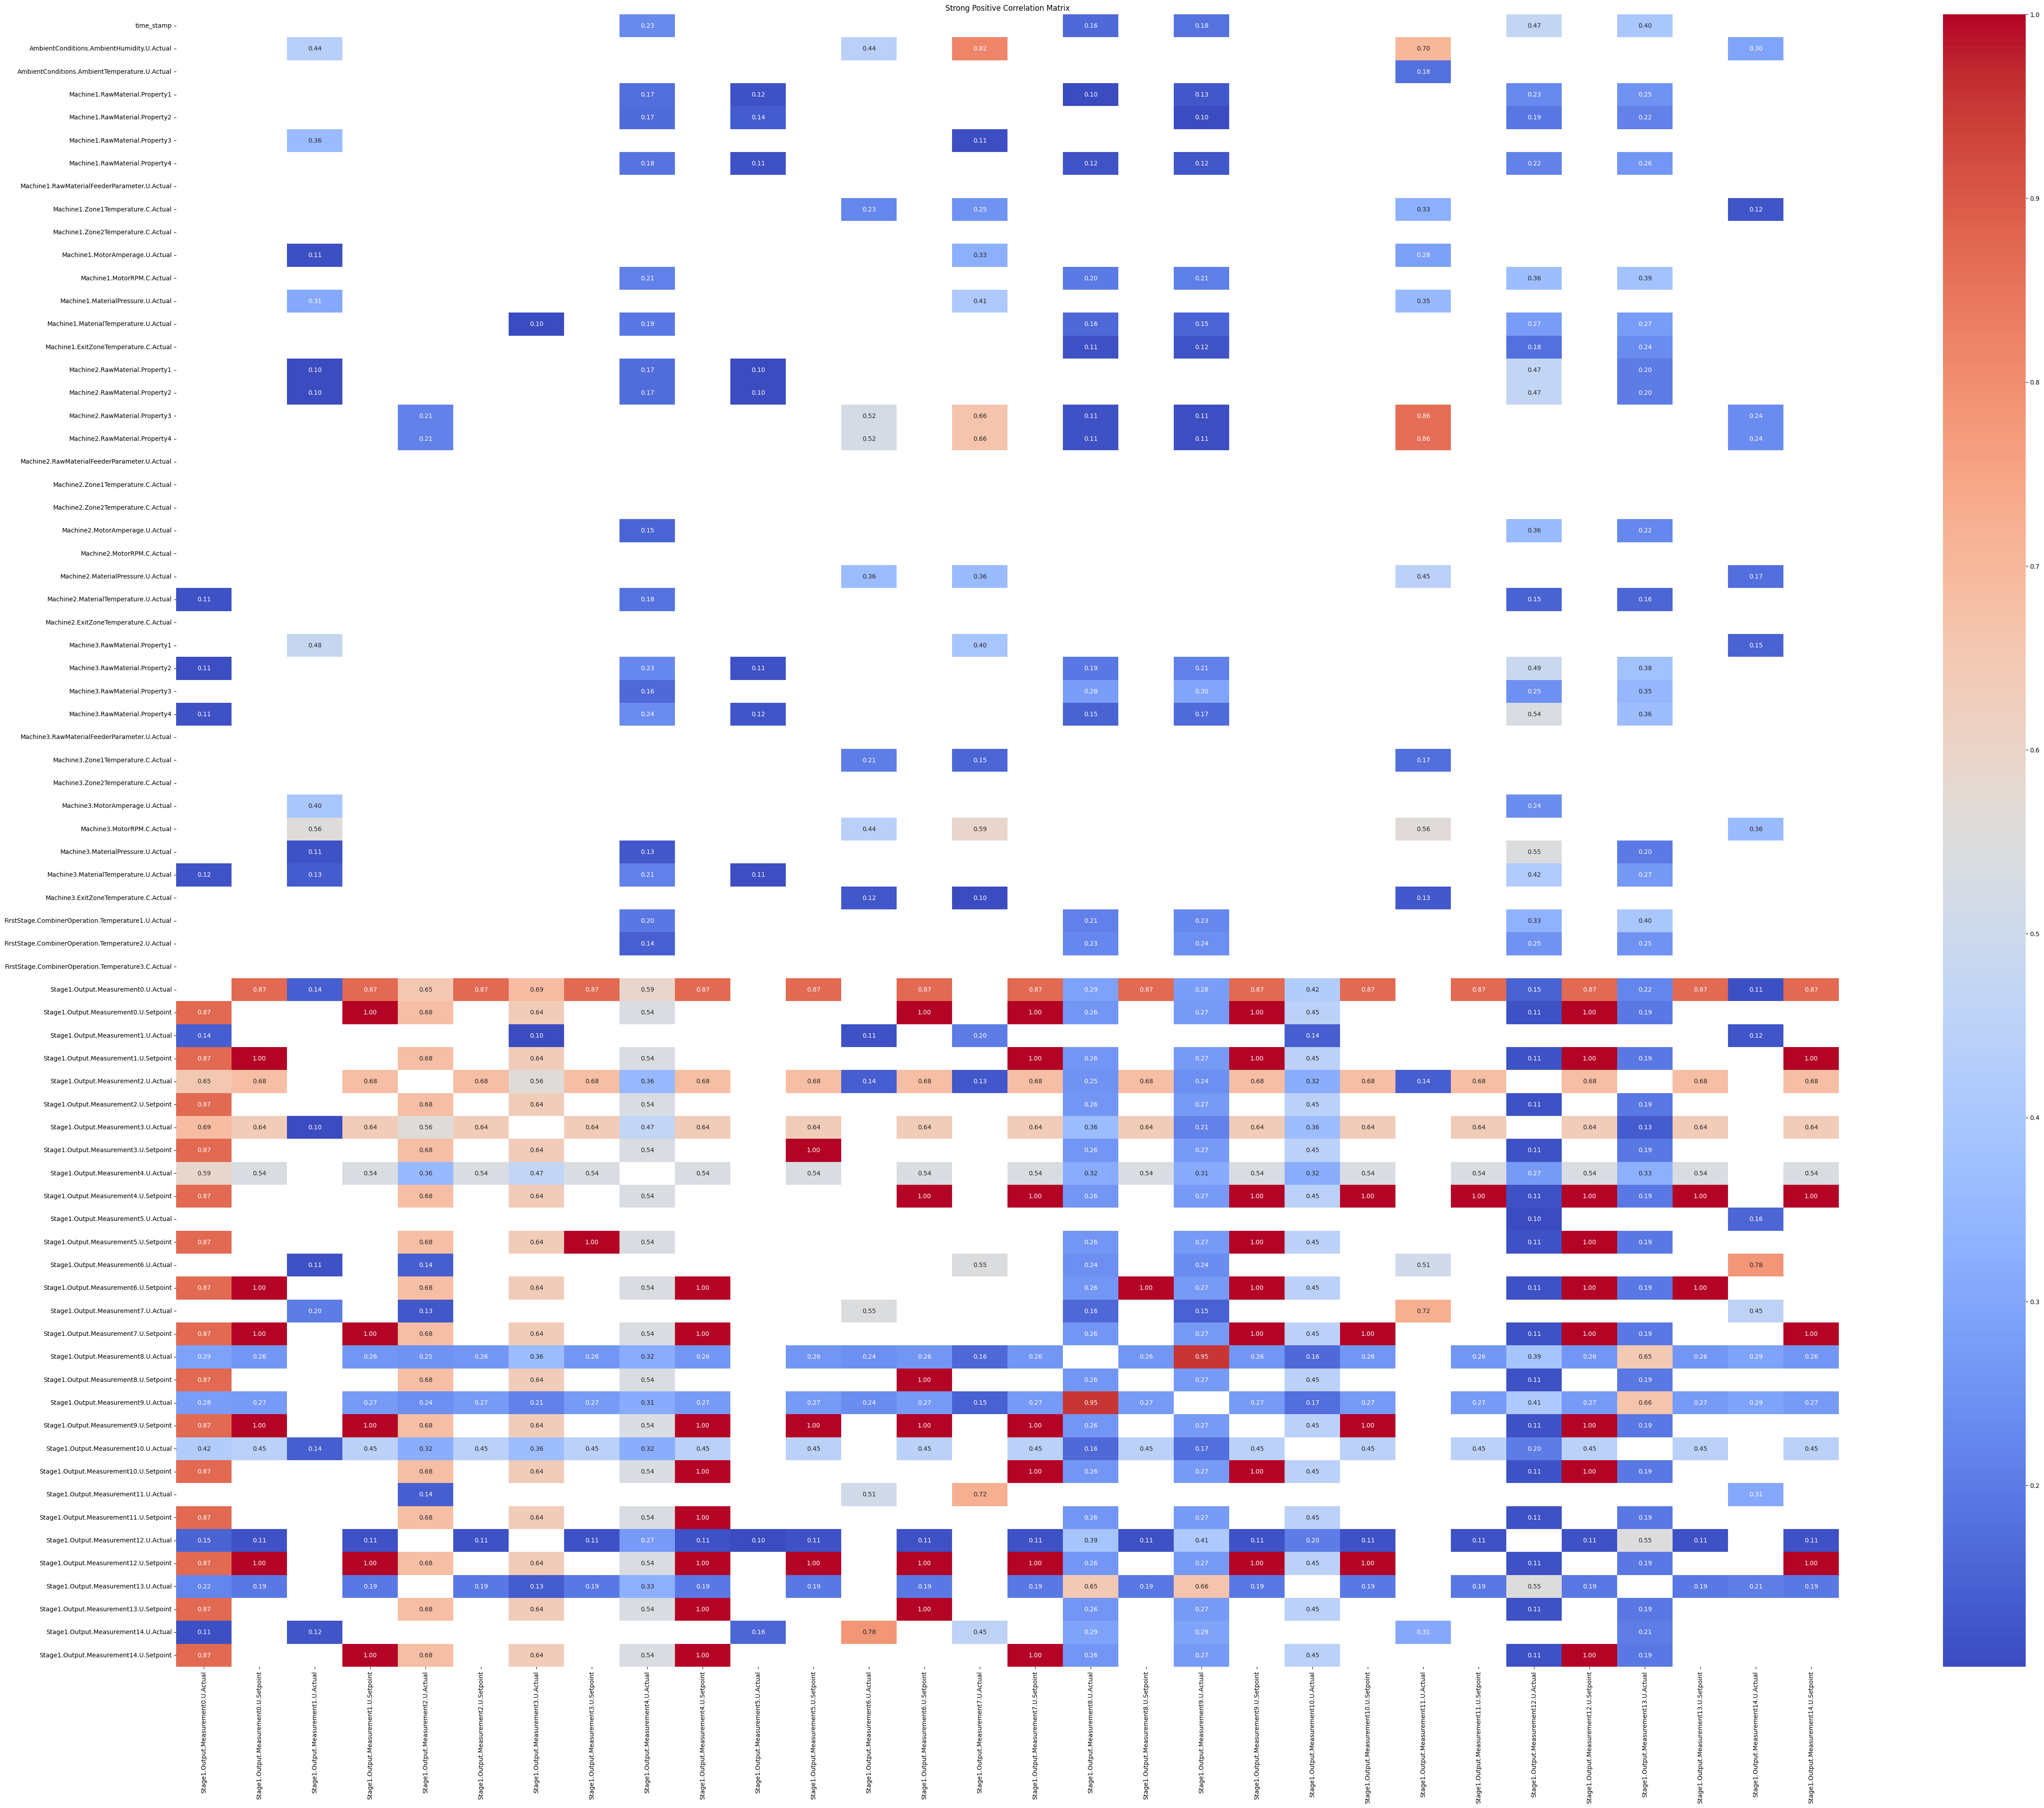

In [286]:
correlation_matrix = stage1_features_df.corr()

correlation_matrix = correlation_matrix.drop(columns=correlation_matrix.columns.difference(stage1_measurement_features))

strong_positive_correlations = correlation_matrix[
    (correlation_matrix > 0.1) & (correlation_matrix < 1)
]

plt.figure(figsize=(60, 48))
sns.heatmap(strong_positive_correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Strong Positive Correlation Matrix")
plt.show()

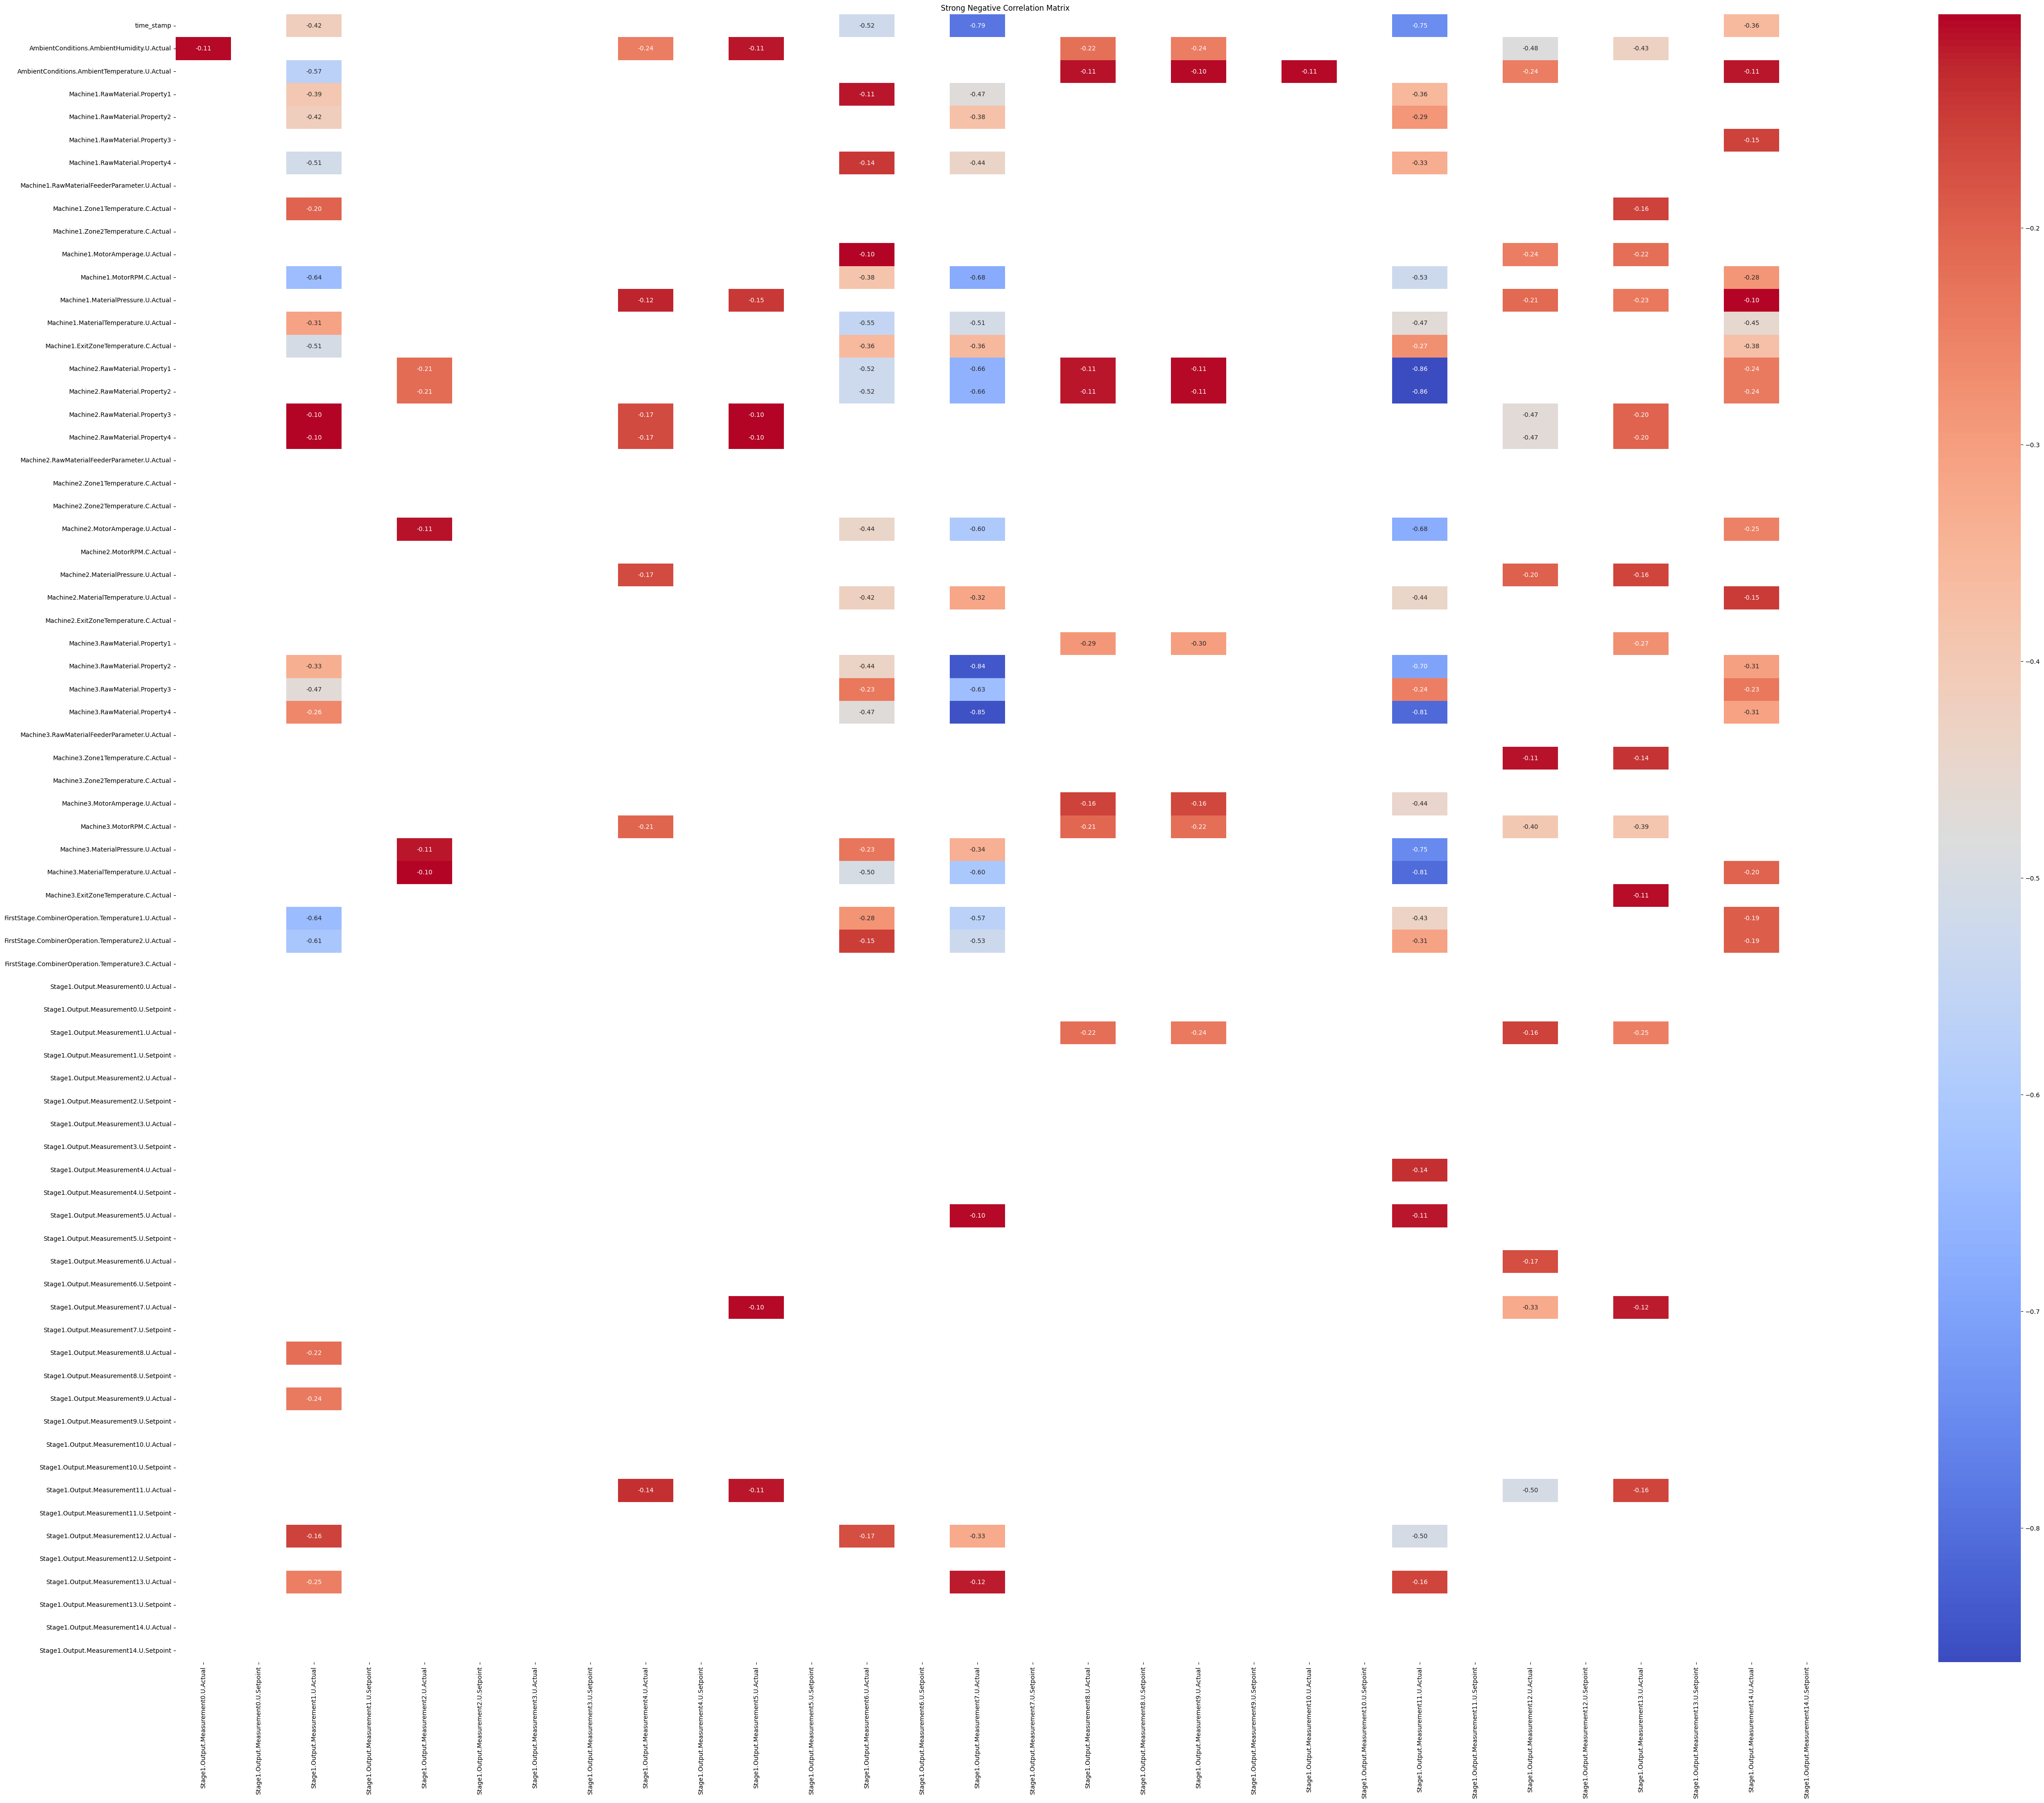

In [287]:
correlation_matrix = stage1_features_df.corr()

correlation_matrix = correlation_matrix.drop(columns=correlation_matrix.columns.difference(stage1_measurement_features))

strong_negative_correlations = correlation_matrix[
    (correlation_matrix < -0.1) & (correlation_matrix > -1)
]

plt.figure(figsize=(60, 48))
sns.heatmap(strong_negative_correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Strong Negative Correlation Matrix")
plt.show()

### Positieve Correlatie

In [288]:
#Welke marge zictbaar moet zijn in de dataframe
strong_positive_correlations = correlation_matrix[
    (correlation_matrix > 0.1) & (correlation_matrix < 1)
]

#Verwijderen van sommige 'Setpoint' correlaties. Omdat Setpoints die in de hele cyclus hetzelfde blijven uiteraard dezelfde correlatie hebben.
non_corr_comp_features = strong_positive_correlations.columns[strong_positive_correlations.columns.str.contains('Setpoint')]
strong_positive_correlations = strong_positive_correlations.drop(non_corr_comp_features, axis=1)
strong_positive_correlations = strong_positive_correlations.drop(non_corr_comp_features, axis=0)
non_corr_comp_features = strong_positive_correlations.columns[strong_positive_correlations.columns.str.contains('Measurement')]
strong_positive_correlations = strong_positive_correlations.drop(non_corr_comp_features, axis=0)

In [289]:
#Om 'A-B, B-A' vergelijkingen te voorkomen, worden duplicates verwijderd en wordt de index gereset
strong_positive_correlations = strong_positive_correlations.stack().sort_values(ascending=False).to_frame().reset_index()


strong_positive_correlations.columns = ['feature1', 'feature2', 'coff']
strong_positive_correlations[['feature1', 'feature2']] = np.sort(strong_positive_correlations[['feature1', 'feature2']], axis=1)
strong_positive_correlations = strong_positive_correlations.drop_duplicates(subset=['feature1', 'feature2'])
strong_positive_correlations.reset_index()
strong_positive_correlations

,feature1,feature2,coff
0,Machine2.RawMaterial.Property4,Stage1.Output.Measurement11.U.Actual,0.861889
1,Machine2.RawMaterial.Property3,Stage1.Output.Measurement11.U.Actual,0.861889
2,AmbientConditions.AmbientHumidity.U.Actual,Stage1.Output.Measurement7.U.Actual,0.819419
3,AmbientConditions.AmbientHumidity.U.Actual,Stage1.Output.Measurement11.U.Actual,0.703969
4,Machine2.RawMaterial.Property4,Stage1.Output.Measurement7.U.Actual,0.663963
...,...,...,...
140,Machine2.RawMaterial.Property1,Stage1.Output.Measurement1.U.Actual,0.103225
141,Machine3.ExitZoneTemperature.C.Actual,Stage1.Output.Measurement7.U.Actual,0.102242
142,Machine2.RawMaterial.Property2,Stage1.Output.Measurement5.U.Actual,0.101704
143,Machine2.RawMaterial.Property1,Stage1.Output.Measurement5.U.Actual,0.101704


De beste features voor Measurement.U.Actuals zijn af te leiden van feature1

### Negatieve Correlatie

In [290]:
#Welke marge zictbaar moet zijn in de dataframe
strong_negative_correlations = correlation_matrix[
    (correlation_matrix < -0.1) & (correlation_matrix > -1)
]

In [291]:
#Verwijderen van sommige 'Setpoint' correlaties. Omdat Setpoints die in de hele cyclus hetzelfde blijven uiteraard dezelfde correlatie hebben.
non_corr_comp_features = strong_negative_correlations.columns[strong_negative_correlations.columns.str.contains('Setpoint')]
strong_negative_correlations = strong_negative_correlations.drop(non_corr_comp_features, axis=1)
strong_negative_correlations = strong_negative_correlations.drop(non_corr_comp_features, axis=0)
non_corr_comp_features = strong_negative_correlations.columns[strong_negative_correlations.columns.str.contains('Measurement')]
strong_negative_correlations = strong_negative_correlations.drop(non_corr_comp_features, axis=0)

In [292]:
#Om 'A-B, B-A' vergelijkingen te voorkomen, worden duplicates verwijderd en wordt de index gereset
strong_negative_correlations = strong_negative_correlations.stack().sort_values(ascending=False).to_frame().reset_index()


strong_negative_correlations.columns = ['feature1', 'feature2', 'coff']
strong_negative_correlations[['feature1', 'feature2']] = np.sort(strong_negative_correlations[['feature1', 'feature2']], axis=1)
strong_negative_correlations = strong_negative_correlations.drop_duplicates(subset=['feature1', 'feature2'])
strong_negative_correlations.reset_index()
strong_negative_correlations

,feature1,feature2,coff
0,Machine1.MaterialPressure.U.Actual,Stage1.Output.Measurement14.U.Actual,-0.101358
1,Machine2.RawMaterial.Property3,Stage1.Output.Measurement5.U.Actual,-0.101704
2,Machine2.RawMaterial.Property4,Stage1.Output.Measurement5.U.Actual,-0.101704
3,Machine1.MotorAmperage.U.Actual,Stage1.Output.Measurement6.U.Actual,-0.102503
4,Machine2.RawMaterial.Property4,Stage1.Output.Measurement1.U.Actual,-0.103225
...,...,...,...
134,Machine3.RawMaterial.Property4,Stage1.Output.Measurement11.U.Actual,-0.809484
135,Machine3.RawMaterial.Property2,Stage1.Output.Measurement7.U.Actual,-0.841172
136,Machine3.RawMaterial.Property4,Stage1.Output.Measurement7.U.Actual,-0.850913
137,Machine2.RawMaterial.Property1,Stage1.Output.Measurement11.U.Actual,-0.861889


In [298]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
import pickle

# Assuming df is your DataFrame
df = pd.read_csv("continuous_factory_process.csv", delimiter=",")
# X represents input features (sensor readings from Machines 1 to 3)
# y represents the target variable (measurements of the 15 features after the first stage)
# Specify the list of prefixes you want to filter
prefixes_to_match = ['Machine1', 'Machine2' , 'Machine3', 'time_stamp']

# Use list comprehension to filter columns based on prefixes
filtered_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in prefixes_to_match)]


X = df[filtered_columns]
X = X.drop('time_stamp', axis=1) 
print(X.columns.tolist())

y = df[['Stage1.Output.Measurement0.U.Actual', 'Stage1.Output.Measurement1.U.Actual',
        'Stage1.Output.Measurement2.U.Actual', 'Stage1.Output.Measurement3.U.Actual',
        'Stage1.Output.Measurement4.U.Actual', 'Stage1.Output.Measurement5.U.Actual',
        'Stage1.Output.Measurement6.U.Actual', 'Stage1.Output.Measurement7.U.Actual',
        'Stage1.Output.Measurement8.U.Actual', 'Stage1.Output.Measurement9.U.Actual',
        'Stage1.Output.Measurement10.U.Actual', 'Stage1.Output.Measurement11.U.Actual',
        'Stage1.Output.Measurement12.U.Actual', 'Stage1.Output.Measurement13.U.Actual',
        'Stage1.Output.Measurement14.U.Actual']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a multilinear regression model
model = LinearRegression()


# Train the model
model.fit(X_train_scaled, y_train)

with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


['Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2', 'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4', 'Machine1.RawMaterialFeederParameter.U.Actual', 'Machine1.Zone1Temperature.C.Actual', 'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual', 'Machine1.MotorRPM.C.Actual', 'Machine1.MaterialPressure.U.Actual', 'Machine1.MaterialTemperature.U.Actual', 'Machine1.ExitZoneTemperature.C.Actual', 'Machine2.RawMaterial.Property1', 'Machine2.RawMaterial.Property2', 'Machine2.RawMaterial.Property3', 'Machine2.RawMaterial.Property4', 'Machine2.RawMaterialFeederParameter.U.Actual', 'Machine2.Zone1Temperature.C.Actual', 'Machine2.Zone2Temperature.C.Actual', 'Machine2.MotorAmperage.U.Actual', 'Machine2.MotorRPM.C.Actual', 'Machine2.MaterialPressure.U.Actual', 'Machine2.MaterialTemperature.U.Actual', 'Machine2.ExitZoneTemperature.C.Actual', 'Machine3.RawMaterial.Property1', 'Machine3.RawMaterial.Property2', 'Machine3.RawMaterial.Property3', 'Machin

In [300]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the combined results
with open(r'D:\dtc-dr\combined_results.json', 'r') as combined_file:
    combined_results = json.load(combined_file)

# Extract the data for plotting
target_variables = list(combined_results.keys())

# Initialize lists to store the scores for each model and target variable
regression_train_scores = []
regression_test_scores = []
decision_tree_train_scores = []
decision_tree_test_scores = []

# Populate the lists with the respective scores
for col in target_variables:
    regression_train_scores.append(combined_results[col]['regression'][0])
    regression_test_scores.append(combined_results[col]['regression'][1])
    decision_tree_train_scores.append(combined_results[col]['decision_tree'][0])
    decision_tree_test_scores.append(combined_results[col]['decision_tree'][1])

# Create a bar chart for each target variable
bar_width = 0.1
index = np.arange(len(target_variables))

fig, ax = plt.subplots(figsize=(15, 8))

bar1 = ax.bar(index - bar_width, regression_train_scores, bar_width, label='Regression Train', color='blue')
bar2 = ax.bar(index, regression_test_scores, bar_width, label='Regression Test', color='orange')
bar3 = ax.bar(index + bar_width, decision_tree_train_scores, bar_width, label='Decision Tree Train', color='green', alpha=0.7)
bar4 = ax.bar(index + 2*bar_width, decision_tree_test_scores, bar_width, label='Decision Tree Test', color='red', alpha=0.7)

ax.set_xlabel('Target Variables')
ax.set_ylabel('R-squared Scores')
ax.set_title('R-squared Scores for Regression and Decision Tree Models')
ax.set_xticks(index)
ax.set_xticklabels(target_variables, rotation=45)
ax.legend()

# Save the chart as an image
plt.savefig('bar_chart.png')

# Show the chart
plt.show()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)